## Low mass diphoton analysis
### Parametric neural network for signal and background classification (step 3): 
* **use the model** trained in `trainingParametricNN_nearestPoint.ipynb`
* **save NNScore in the testing trees** 

**SETUP**: Notebook running in [SWAN](https://swan.web.cern.ch/swan) or locally in an anaconda environent. In the second case, you might need to install the needed packages to run the notebook, e.g.:
```
conda install -c conda-forge matplotlib
conda install h5py
conda install -c conda-forge pandas
conda install -c conda-forge uproot
conda install uproot-methods
pip install tensorflow
conda install scikit-learn
```

A dedicated package that includes a set of helpers for matplotlib to more easily produce plots with the classic CMS style is installed ([mphep](https://github.com/scikit-hep/mplhep)):
```
pip install mplhep
```

In [1]:
import numpy as np
import math, os, h5py
import pandas as pd
import ROOT
import uproot

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
import sklearn

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import mplhep as hep

Welcome to JupyROOT 6.28/00


In [2]:
########################################################################
# Inputs: input files and input trees, training variables, mass points #
########################################################################

approach = "nearest"
#approach = "random"

model_file = "models/model_WeightedCrossEntropyLoss_nearestPoint_100_epochs80.h5"

mass_points = [5, 15, 25, 35, 45, 55, 65]

# List of signal files:
file_names_sig = [
    'NTUPLES_Oct2023/ggh/ggH_M5_merged.root',    
    'NTUPLES_Oct2023/ggh/ggH_M15_merged.root',    
    'NTUPLES_Oct2023/ggh/ggH_M25_merged.root',
    'NTUPLES_Oct2023/ggh/ggH_M35_merged.root',
    'NTUPLES_Oct2023/ggh/ggH_M45_merged.root',
    'NTUPLES_Oct2023/ggh/ggH_M55_merged.root',
    'NTUPLES_Oct2023/ggh/ggH_M65_merged.root' 
]

# List of signal tree names
tree_names_sig = [
    'ggh_5_13TeV_UntaggedTag_0',
    'ggh_15_13TeV_UntaggedTag_0',
    'ggh_25_13TeV_UntaggedTag_0',
    'ggh_35_13TeV_UntaggedTag_0',
    'ggh_45_13TeV_UntaggedTag_0',
    'ggh_55_13TeV_UntaggedTag_0',
    'ggh_65_13TeV_UntaggedTag_0'
]

# Using the sideband tree for the data
file_names_bkg = [
    'NTUPLES_Oct2023/data/data_EGamma_2018.root',
    'NTUPLES_Oct2023/output_ParaDDFull_wsig_10step.root'
]

# List of background tree names
tree_names_bkg = [
    'Data_13TeV_UntaggedTag_0',
    'mgg_bkg_13TeV_UntaggedTag_0'
]

# Variables used for training the model 
vars_list = [
    'dipho_lead_ptoM', 'dipho_sublead_ptoM',
    'dipho_leadIDMVA', 'dipho_subleadIDMVA',
    'leadEta', 'subleadEta',
    'sigmaMrvoM', 'sigmaMwvoM',
    'cosphi', 'vtxprob',
    'CMS_hgg_mass'
]

# Standardizing variables ranges: reference values used in the training
# ---------------------------------------------------------------------
# Nearest
mean_REF = np.array([1.02221586e+00, 5.92401851e-01, 3.51856716e-01, 1.73320566e-01, 1.37241799e-03, 1.43889548e-03, 1.98240597e-02, 2.66782502e-02, -2.30134385e-01, 7.54484348e-01, 5.10071833e+01])
std_REF = np.array([0.7890904, 0.40491352, 0.58262894, 0.59625774, 1.00148242, 0.9676065, 0.02543319, 0.02461514, 0.77499453, 0.26648426, 16.91191081])

# Random
#mean_REF =  np.array([9.92453636e-01, 5.76560285e-01, 3.64651421e-01, 1.86627699e-01, 1.89154785e-03, 1.51795157e-03, 1.95562936e-02, 2.63900476e-02, -2.68335983e-01, 7.53037223e-01, 4.09308475e+01])
#std_REF =  np.array([0.79372193, 0.41348133, 0.57886452, 0.59570215, 1.00704125, 0.97323678, 0.02527091, 0.02446731, 0.7649603, 0.26688041, 20.21055606])
    
# Random wsig
#mean_REF =  np.array([1.02221586e+00,5.92401851e-01,3.51856716e-01,1.73320566e-01, 1.37241799e-03, 1.43889548e-03, 1.98240597e-02, 2.66782502e-02, -2.30134385e-01,7.54484348e-01,4.09169098e+01])
#std_REF =  np.array([ 0.7890904, 0.40491352, 0.58262894, 0.59625774, 1.00148242, 0.9676065, 0.02543319, 0.02461514, 0.77499453, 0.26648426,20.19474733])

In [3]:
######################################################
# Parametric classifier and loss function definition #
######################################################
class ParametricClassifier(Model):
    def __init__(self, input_shape, architecture=[1, 4, 1], activation='relu', name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        kernel_constraint = None
        self.hidden_layers = [Dense(architecture[i+1], input_shape=(architecture[i],), activation=activation) for i in range(len(architecture)-2)]
        self.output_layer  = Dense(architecture[-1], input_shape=(architecture[-2],), activation='linear')
        self.build(input_shape)
        
    def call(self, x):
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = hidden_layer(x)
        x = self.output_layer(x)
        return x

def QuadraticLoss(true, pred):
    y = true[:, 1] #taken from the true_label definition 
    w = true[:, 0] #taken from the true_label definition 
    f = pred[:, 0]
    c = 1./(1+tf.exp(f))
    return 1000*tf.reduce_mean(y*w*c**2 + (1-y)*w*(1-c)**2)
 
def WeightedCrossEntropyLoss(true, pred):
    y   = true[:, 1] #taken from the true_label definition 
    w   = true[:, 0] #taken from the true_label definition
    f   = pred[:, 0]
    return tf.reduce_sum((1-y)*w*tf.math.log(1+tf.exp(f)) + y*w*tf.math.log(1+tf.exp(-1*f))) #activation='linear'

#####################
# Model declaration #
#####################
architecture = [11, 100, 100, 100, 1] # f(x, m) = NN(x, {w}, {b}) || f(x, m) = m * NN(x, {w}, {b})
model = ParametricClassifier(input_shape=(None, 11), architecture=architecture, activation='relu')
optimizer = tf.keras.optimizers.legacy.Adam()
print(model.summary())

model.compile(loss=WeightedCrossEntropyLoss, # QuadraticLoss
              optimizer=optimizer, 
              #metrics=['binary_accuracy']
             )

model.load_weights(model_file)

# Open the HDF5 file in read-only mode to check the content of the model
# ----------------------------------------------------------------------
with h5py.File(model_file, 'r') as file:
    # Print the keys at the root level of the HDF5 file
    print("Root keys:", list(file.keys()))
    
    print("Contents of 'dense':", list(file['dense'])) # weights and vias for each layer
    print("Contents of 'dense_1':", list(file['dense_1']))
    print("Contents of 'dense_2':", list(file['dense_2']))
    print("Contents of 'dense_3':", list(file['dense_3']))
    
    # Access a specific group or dataset within the HDF5 file
    if 'top_level_model_weights' in file:
        print("Contents of 'top_level_model_weights':", list(file['top_level_model_weights']))
    else:
        print("Group or dataset 'top_level_model_weights' not found.")
        
with h5py.File(model_file, 'r') as file:
    layer_weights = file['dense']['dense']
    print("Weights of dense layer:", layer_weights)
    
        
with h5py.File(model_file, 'r') as file:
    layer_weights = file['dense_1']['dense_1']
    print("Weights of dense_1 layer:", layer_weights)
    
        
with h5py.File(model_file, 'r') as file:
    layer_weights = file['dense_2']['dense_2']
    print("Weights of dense_2 layer:", layer_weights)
    
        
with h5py.File(model_file, 'r') as file:
    layer_weights = file['dense_3']['dense_3']
    print("Weights of dense_3 layer:", layer_weights)

Model: "parametric_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  1200      
                                                                 
 dense_1 (Dense)             multiple                  10100     
                                                                 
 dense_2 (Dense)             multiple                  10100     
                                                                 
 dense_3 (Dense)             multiple                  101       
                                                                 
Total params: 21501 (83.99 KB)
Trainable params: 21501 (83.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Root keys: ['dense', 'dense_1', 'dense_2', 'dense_3', 'top_level_model_weights']
Contents of 'dense': ['dense']
Contents of 'dense_1': [

In [4]:
#########################
# Building the datasets #
#########################

# ---------- #
# BACKGROUND #   
# ---------- #
array_bkg_data = []
array_bkg_dipho = []

# Loop to get the values for each column for the bkg sample
# ---------------------------------------------------------
for f, tree_name_bkg in enumerate(tree_names_bkg):
    file_name_bkg = file_names_bkg[f]
    file = ROOT.TFile.Open(file_name_bkg)
    tree = file.Get("tagsDumper/trees/" + tree_name_bkg)
    rdf = ROOT.RDataFrame(tree)

    if (f==0):
        npdf_data = rdf.AsNumpy(vars_list)
        array_bkg_data.append(npdf_data)
    elif (f==1):
        npdf_dipho = rdf.AsNumpy(vars_list)
        array_bkg_dipho.append(npdf_dipho)
        
bkg_data_col = [np.hstack([b[var] for b in array_bkg_data]) for var in vars_list]
bkg_data = np.column_stack(bkg_data_col)

bkg_dipho_col = [np.hstack([bmc[var] for bmc in array_bkg_dipho]) for var in vars_list]
bkg_dipho = np.column_stack(bkg_dipho_col)

# ---------- #
#   SIGNAL   #
# ---------- #
array_sig5 = []
array_sig15 = []
array_sig25 = []
array_sig35 = []
array_sig45 = []
array_sig55 = []
array_sig65 = []

# Loop to get the values for each column for signal samples
# ---------------------------------------------------------
for f, tree_name_sig in enumerate(tree_names_sig):
    file_name_sig = file_names_sig[f]
    file = ROOT.TFile.Open(file_name_sig)
    tree = file.Get("tagsDumper/trees/" + tree_name_sig)
    #tree.Print()
    rdf = ROOT.RDataFrame(tree)
    #npdf = rdf.AsNumpy(vars_list)
    
    if (f==0):
        npdf5 = rdf.AsNumpy(vars_list)
        array_sig5.append(npdf5)
    elif (f==1):
        npdf15 = rdf.AsNumpy(vars_list)
        array_sig15.append(npdf15)
    elif (f==2):
        npdf25 = rdf.AsNumpy(vars_list)
        array_sig25.append(npdf25)
    elif (f==3):
        npdf35 = rdf.AsNumpy(vars_list)
        array_sig35.append(npdf35)
    elif (f==4):
        npdf45 = rdf.AsNumpy(vars_list)
        array_sig45.append(npdf45)
    elif (f==5):
        npdf55 = rdf.AsNumpy(vars_list)
        array_sig55.append(npdf55)
    elif (f==6):
        npdf65 = rdf.AsNumpy(vars_list)
        array_sig65.append(npdf65)

sig5_col = [np.hstack([s[var] for s in array_sig5]) for var in vars_list]
sig5 = np.column_stack(sig5_col)

sig15_col = [np.hstack([s[var] for s in array_sig15]) for var in vars_list]
sig15 = np.column_stack(sig15_col)

sig25_col = [np.hstack([s[var] for s in array_sig25]) for var in vars_list]
sig25 = np.column_stack(sig25_col)

sig35_col = [np.hstack([s[var] for s in array_sig35]) for var in vars_list]
sig35 = np.column_stack(sig35_col)

sig45_col = [np.hstack([s[var] for s in array_sig45]) for var in vars_list]
sig45 = np.column_stack(sig45_col)

sig55_col = [np.hstack([s[var] for s in array_sig55]) for var in vars_list]
sig55 = np.column_stack(sig55_col)

sig65_col = [np.hstack([s[var] for s in array_sig65]) for var in vars_list]
sig65 = np.column_stack(sig65_col)

In [5]:
####################################
# --STANDARDIZING VARIABLES RANGES #
####################################
# Make the dataset invariant for scale effects.
# Rule to transform data to be in a proper shape to apply the model

def standardize_dataset(data, mean, std):
    return (data - mean) / std

sig5 = standardize_dataset(sig5, mean_REF, std_REF)
sig15 = standardize_dataset(sig15, mean_REF, std_REF)
sig25 = standardize_dataset(sig25, mean_REF, std_REF)
sig35 = standardize_dataset(sig35, mean_REF, std_REF)
sig45 = standardize_dataset(sig45, mean_REF, std_REF)
sig55 = standardize_dataset(sig55, mean_REF, std_REF)
sig65 = standardize_dataset(sig65, mean_REF, std_REF)
bkg_data = standardize_dataset(bkg_data, mean_REF, std_REF)
bkg_dipho = standardize_dataset(bkg_dipho, mean_REF, std_REF)

In [6]:
# Create a dictionary with NN scores for the MC signal events 
preds_dict = {mass: tf.sigmoid(model.predict(sig[:, :])).numpy()[:, 0] for mass, sig in zip(mass_points, [sig5, sig15, sig25, sig35, sig45, sig55, sig65])}

# Make predictions for background data
predsBkg_data = tf.sigmoid(model.predict(bkg_data[:, :])).numpy()[:, 0]
# Make predictions for background mc (diphoton)
predsBkg_dipho = tf.sigmoid(model.predict(bkg_dipho[:, :])).numpy()[:, 0]

20092/20092 [==============================] - 9s 449us/step


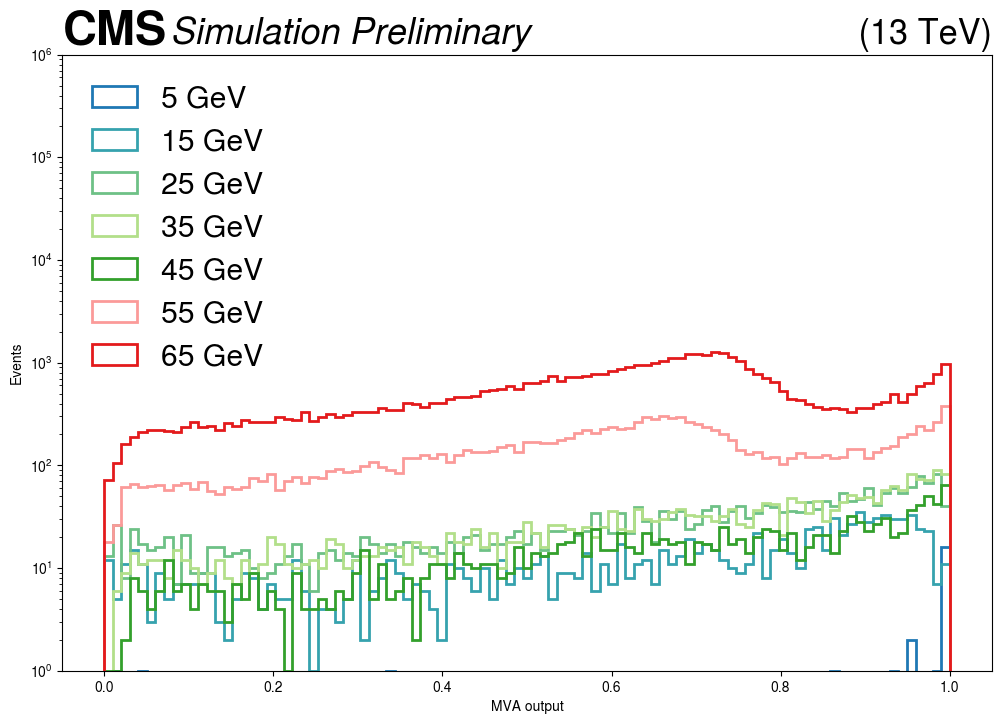

In [7]:
colors = ['#1f78b4', '#36a2ae', '#6ec186', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']

fig, ax = plt.subplots(figsize=(12, 8))

# Loop through each prediction array and plot it with a different color
for mass, color in zip(mass_points, colors):
    preds = preds_dict[mass]
    ax.hist(preds, bins=np.linspace(0., 1., 100), color=color, label=f'{mass} GeV', histtype='step', linewidth=2)

ax.set_yscale('log')
ax.set_ylim(1, 1000000)  # Set y-axis limits
ax.set_xlabel('MVA output')
ax.set_ylabel('Events')
ax.legend(loc='upper right')
#plt.yscale('log')
#plt.ylim(1, 25000)  # Set y-axis limits
#plt.xlabel("MVA output")
#plt.ylabel("Events")

plt.style.use(hep.style.ROOT)
hep.cms.label("Preliminary", data=False)

plt.legend()
plt.savefig("Plots/"+approach+"/MVAOutputs/massSpectrum/allMVAOutputs.png")
plt.savefig("Plots/"+approach+"/MVAOutputs/massSpectrum/allMVAOutputs.pdf")
#plt.show()

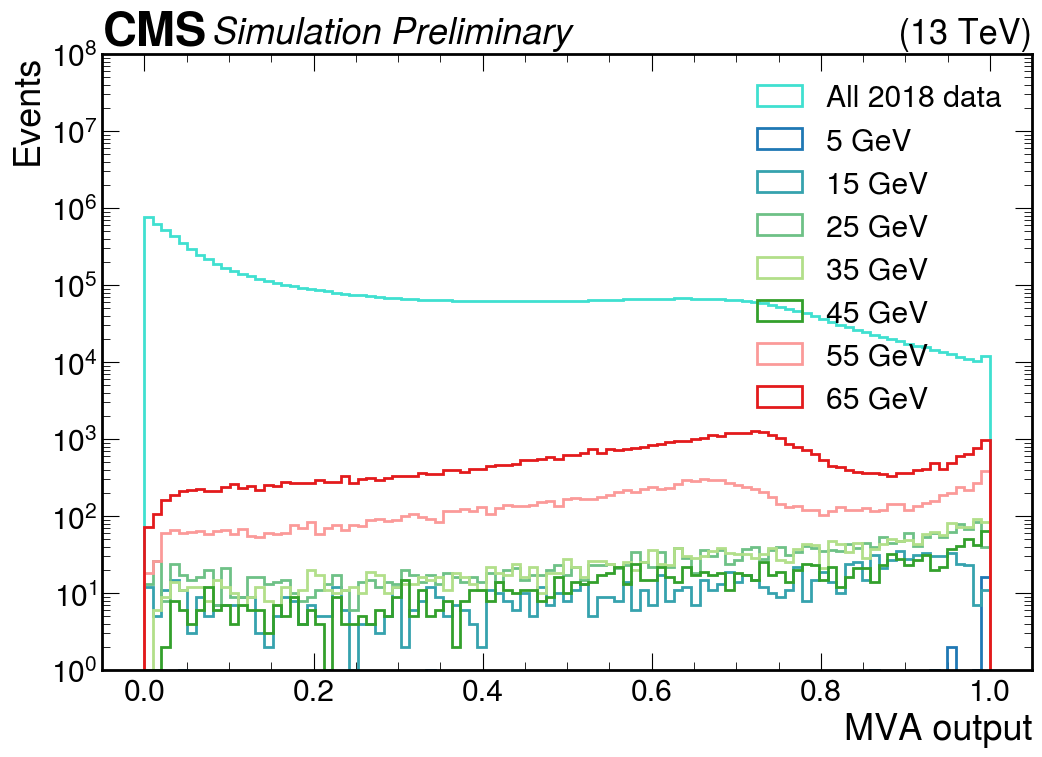

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(predsBkg_data, bins=np.linspace(0., 1., 100), color="turquoise", label='All 2018 data', histtype='step', linewidth=2)

# Loop through each prediction array and plot it with a different color
for mass, color in zip(mass_points, colors):
    preds = preds_dict[mass]
    ax.hist(preds, bins=np.linspace(0., 1., 100), color=color, label=f'{mass} GeV', histtype='step', linewidth=2)

ax.set_yscale('log')
ax.set_ylim(1, 100000000)  # Set y-axis limits
ax.set_xlabel('MVA output')
ax.set_ylabel('Events')
ax.legend(loc='upper right')
#plt.yscale('log')
#plt.ylim(1, 25000)  # Set y-axis limits
#plt.xlabel("MVA output")
#plt.ylabel("Events")

plt.style.use(hep.style.ROOT)
hep.cms.label("Preliminary", data=False)

plt.legend()
plt.savefig("Plots/"+approach+"/MVAOutputs/massSpectrum/allMVAOutputs_plusBkg_allData.png")
plt.savefig("Plots/"+approach+"/MVAOutputs/massSpectrum/allMVAOutputs_plusBkg_allData.pdf")
plt.show()

In [9]:
#################################################
# Add prediction to ROOT trees: signal samples  #
#################################################

import ROOT
from array import array

ROOT.gROOT.SetBatch()
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

# Loop over each mass point
for mass_point in mass_points:
    print(f"Processing mass point {mass_point} GeV")

    # Open the input file for the current mass point
    infile_name = f"NTUPLES_Oct2023/ggh/ggH_M{mass_point}_merged.root"
    infile = ROOT.TFile(infile_name, "read")

    # Create a new output file for the current mass point
    outfile_name = "NTUPLES_Oct2023/newFiles/"+approach+"/out_ggH_M"+str(mass_point)+"_merged_v3.root"
    newfile_data = ROOT.TFile(outfile_name, "recreate")

    # Create the necessary directories
    tagsDumper = newfile_data.mkdir("tagsDumper")
    tagsDumper.cd()
    trees = tagsDumper.mkdir("trees")

    # Get the old tree from the input file for the corresponding mass point
    oldtree = infile.Get(f"tagsDumper/trees/ggh_{mass_point}_13TeV_UntaggedTag_0")
    nentries = oldtree.GetEntries()
    print("nentries = ", nentries)

    # Create a new tree with the same structure
    NNScore = array('f', [0.])
    newtree = oldtree.CloneTree(0)
    newtree.Branch("NNScore", NNScore, "NNScore/F")

    # Loop over the entries and fill the new tree with random values
    count = 0
    print("---------- Opening the tree")
    for i in oldtree:
        NNScore[0] = preds_dict[mass_point][count]
        newtree.Fill()
        count += 1

    print("---------- Save and close the tree")
    # Save the new tree to the new file
    trees.cd()
    newtree.Write()

    # Close the current input file
    infile.Close()
    # Close the output file for the current mass point
    newfile_data.Close()

Processing mass point 5 GeV
nentries =  24
---------- Opening the tree
---------- Save and close the tree
Processing mass point 15 GeV
nentries =  1163
---------- Opening the tree
---------- Save and close the tree
Processing mass point 25 GeV
nentries =  2625
---------- Opening the tree
---------- Save and close the tree
Processing mass point 35 GeV
nentries =  2599
---------- Opening the tree
---------- Save and close the tree
Processing mass point 45 GeV
nentries =  1425
---------- Opening the tree
---------- Save and close the tree
Processing mass point 55 GeV
nentries =  13918
---------- Opening the tree
---------- Save and close the tree
Processing mass point 65 GeV
nentries =  52410
---------- Opening the tree
---------- Save and close the tree


In [10]:
#########################################################
# Add prediction to ROOT trees: diphoton MC background  #
#########################################################

# Open the input file: SB data events
infile = ROOT.TFile("NTUPLES_Oct2023/output_ParaDDFull_wsig_10step.root", "read")
# Create a new output files
newfile_dipho = ROOT.TFile("NTUPLES_Oct2023/newFiles/"+approach+"/out_dipho_bkg_v3.root", "recreate")

# Create the necessary directories
tagsDumper = newfile_dipho.mkdir("tagsDumper")
tagsDumper.cd()
trees = tagsDumper.mkdir("trees")

# Get the old tree from the input file
oldtree = infile.Get("tagsDumper/trees/mgg_bkg_13TeV_UntaggedTag_0")
nentries = oldtree.GetEntries()
print("nentries = ", nentries)

# Create a new tree with the same structure
NNScore = array('f', [0.])
newtree = oldtree.CloneTree(0)
newtree.Branch("NNScore", NNScore, "NNScore/F")
    
# Loop over the entries and fill the new tree with random values
print("---------- Opening the sb data tree")
count = 0
for i in oldtree:
    #if (count == 1000): break
    NNScore[0] = predsBkg_dipho[count]
    newtree.Fill()
    count += 1
    
print("---------- Save and close the sb data tree")
# Save the new tree to the new file
trees.cd()
newtree.Write()
newfile_dipho.Close()

nentries =  642942
---------- Opening the sb data tree
---------- Save and close the sb data tree


In [11]:
#############################################
# Add prediction to ROOT trees: background  #
#############################################

# Open the input file: SB data events
#infile = ROOT.TFile("NTUPLES_Oct2023/output_ParaDDFull_wsig_10step.root", "read")
# Create a new output files
#newfile_data = ROOT.TFile("NTUPLES_Oct2023/newFiles/out_sbData_bkg_v2.root", "recreate")

# Open the input file: all 2018 data events
infile = ROOT.TFile("NTUPLES_Oct2023/data/data_EGamma_2018.root", "read")

# Create a new output file
newfile_data = ROOT.TFile("NTUPLES_Oct2023/newFiles/"+approach+"/out_all2018Data_bkg_v3.root", "recreate")

# Create the necessary directories
tagsDumper = newfile_data.mkdir("tagsDumper")
tagsDumper.cd()
trees = tagsDumper.mkdir("trees")

# Get the old tree from the input file
oldtree = infile.Get("tagsDumper/trees/Data_13TeV_UntaggedTag_0")
nentries = oldtree.GetEntries()
print("nentries = ", nentries)

# Create a new tree with the same structure
NNScore = array('f', [0.])
newtree = oldtree.CloneTree(0)
newtree.Branch("NNScore", NNScore, "NNScore/F")
    
# Loop over the entries and fill the new tree with random values
print("---------- Opening the full data tree")
count = 0
for i in oldtree:
    #if (count == 1000): break
    if count % 500000 == 0:
        print(f"Processed {count} events")
    NNScore[0] = predsBkg_data[count]
    newtree.Fill()
    count += 1
    
print("---------- Save and close the full data tree")
# Save the new tree to the new file
trees.cd()
newtree.Write()
newfile_data.Close()

nentries =  9126267
---------- Opening the full data tree
Processed 0 events
Processed 500000 events
Processed 1000000 events
Processed 1500000 events
Processed 2000000 events
Processed 2500000 events
Processed 3000000 events
Processed 3500000 events
Processed 4000000 events
Processed 4500000 events
Processed 5000000 events
Processed 5500000 events
Processed 6000000 events
Processed 6500000 events
Processed 7000000 events
Processed 7500000 events
Processed 8000000 events
Processed 8500000 events
Processed 9000000 events
---------- Save and close the full data tree
